In [4]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import json
from natsort import natsorted

In [58]:
df = pd.read_csv(f"sarah/level2_norm_ss_renamed.tsv", delimiter="\t")
df = df.set_index("Unnamed: 0")
df2 = df.rename(columns={'SJ3_Bact': ' SJ3_Bact', 'SJ4_Bact': ' SJ4_Bact'})

df = df2.reindex(natsorted(df2.columns), axis=1)
# df.drop(['SJ3_Bact', 'SJ4_Bact'], axis=1)
df.head(3)

,SJ3_Bact,SJ4_Bact,SJ3_B_Na_22_1,SJ3_B_Na_22_1.1,SJ3_B_Na_45_1,SJ3_B_Na_45_2,SJ3_B_Na_45_3,SJ3_B_No_22_1,SJ3_B_No_22_2,SJ3_B_No_22_3,...,SJ4_I_No_22_2,SJ4_I_No_22_3,SJ4_I_No_45_1,SJ4_I_No_45_1.1,SJ4_I_Qi_22_1,SJ4_I_Qi_22_2,SJ4_I_Qi_22_3,SJ4_I_Qi_45_1,SJ4_I_Qi_45_2,SJ4_I_Qi_45_3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Amino Acids and Derivatives;,1075.399163,1317.587717,537.312922,532.456165,380.479859,598.367964,516.810113,560.164582,490.329454,449.012172,...,846.532270,1214.149527,748.102684,1104.821339,520.912506,533.002819,723.528728,608.414237,646.070688,713.212839
"Amino Acids and Derivatives; Alanine, serine, and glycine",2823.628278,3538.684330,6762.094703,6864.265989,7581.465451,6213.097985,6639.227467,6214.702579,6498.007605,7814.282065,...,8289.866224,5030.984407,9105.178661,5391.008520,10601.990022,7300.644478,8690.238246,7913.913638,7838.892734,8013.985941
"Amino Acids and Derivatives; Arginine; urea cycle, creatine, polyamines",15257.802835,17596.675975,11336.371759,10780.786809,9738.720764,11408.354952,11062.908582,11299.687761,10713.786434,10280.173342,...,10680.083853,11381.164094,12383.961485,10826.738027,11625.645872,12813.694687,13285.242573,11998.207000,12364.805207,13314.954545


# Standardise the data

In [11]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled

array([[-0.48630026, -0.53123183, -0.45673289, ..., -0.38148628,
        -0.40092111, -0.46125635],
       [-0.3485321 , -0.33221696, -0.03296847, ...,  0.0383636 ,
         0.03599108,  0.05419496],
       [ 0.63133571,  0.92740833,  0.27843456, ...,  0.27308952,
         0.3109077 ,  0.42845549],
       ...,
       [-0.30396819, -0.39282494, -0.36118427, ..., -0.34052343,
        -0.35022012, -0.40359269],
       [-0.57104646, -0.64926231, -0.49331154, ..., -0.41645208,
        -0.44004314, -0.51161081],
       [-0.38933579, -0.39314901, -0.40995373, ..., -0.35365975,
        -0.37115436, -0.42757765]])

In [12]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

In [16]:
df.shape

(138, 42)

In [15]:
df_pca[:,1].shape

(138,)

In [18]:
df.index.shape

(138,)

In [22]:
labels=list(df.index)
zipped = list(zip(df_pca[:,0],
                  df_pca[:,1],
                  labels))
pc_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', "Label"])
pc_df.head(3)
                     

,PC1,PC2,Label
0,-2.733199,0.238386,Amino Acids and Derivatives;
1,-0.303630,-0.102084,"Amino Acids and Derivatives; Alanine, serine, ..."
2,2.086815,-0.154532,Amino Acids and Derivatives; Arginine; urea cy...


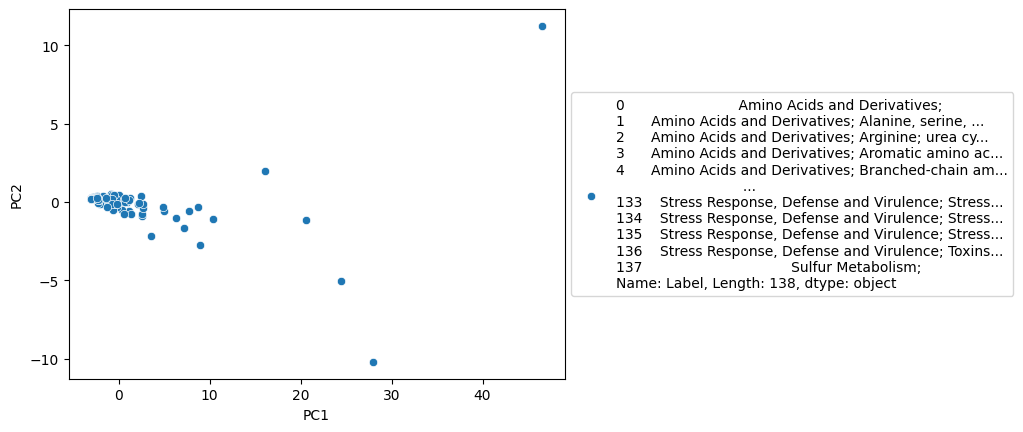

In [26]:
ax = sns.scatterplot(x="PC1", y="PC2", label=pc_df['Label'], data=pc_df)
ax.legend(title="Label")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [27]:
pc_df.shape

(138, 3)

# Transpose the data and plot based on the samples

In [98]:
dft = df.T

In [105]:
pattern = r'(?P<Sample>SJ\d)_(?P<Approach>\w+)_(?P<Method>\w+)_(?P<Filter>\d+)_(?P<Rpt>\d+)'
tmp = dft.index.str.extract(pattern)
cols = ['Sample', 'Approach', 'Method', 'Filter', 'Rpt']
labels = pd.DataFrame()
labels[cols] = tmp[cols].values
labels.at[0, 'Sample'] = 'SJ3_Bact'
labels.at[0, 'Approach'] = 'SJ3_Bact'
labels.at[0, 'Method'] = 'SJ3_Bact'
labels.at[0, 'Filter'] = 'SJ3_Bact'
labels.at[0, 'Rpt'] = 'SJ3_Bact'
labels.at[1, 'Sample'] = 'SJ4_Bact'
labels.at[1, 'Approach'] = 'SJ4_Bact'
labels.at[1, 'Method'] = 'SJ4_Bact'
labels.at[1, 'Filter'] = 'SJ4_Bact'
labels.at[1, 'Rpt'] = 'SJ4_Bact'
labels

,Sample,Approach,Method,Filter,Rpt
0,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact
1,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact
2,SJ3,B,Na,22,1
3,SJ3,B,Na,22,1
4,SJ3,B,Na,45,1
5,SJ3,B,Na,45,2
6,SJ3,B,Na,45,3
7,SJ3,B,No,22,1
8,SJ3,B,No,22,2
9,SJ3,B,No,22,3


In [106]:
scaler = StandardScaler()
scaler.fit(dft)
dft_scaled = scaler.transform(dft)
pca = PCA(n_components=2)
pca.fit(dft_scaled)
dft_pca = pca.transform(dft_scaled)
zipped = list(zip(dft_pca[:,0],
                  dft_pca[:,1],
                  list(dft.index),
                 ))
pct_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', "Label"])
pct_df = pd.concat([pct_df, labels], axis=1)
pct_df.head(3)

,PC1,PC2,Label,Sample,Approach,Method,Filter,Rpt
0,10.572713,4.857448,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact
1,14.179309,0.118877,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact
2,-4.715552,3.028237,SJ3_B_Na_22_1,SJ3,B,Na,22,1


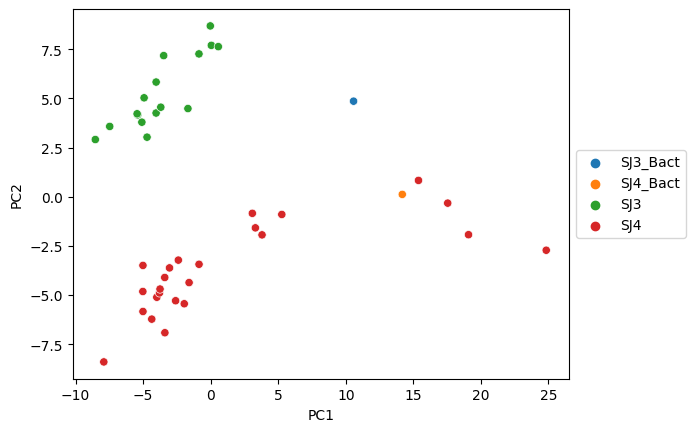

In [108]:
ax = sns.scatterplot(x="PC1", y="PC2", hue='Sample', legend=True, data=pct_df)
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


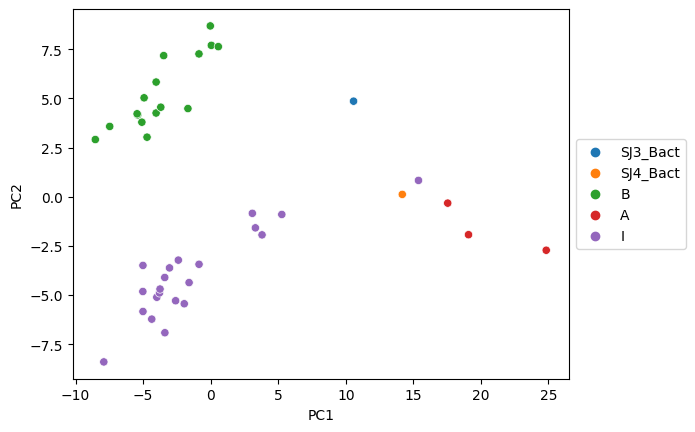

In [109]:
ax = sns.scatterplot(x="PC1", y="PC2", hue='Approach', legend=True, data=pct_df)
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


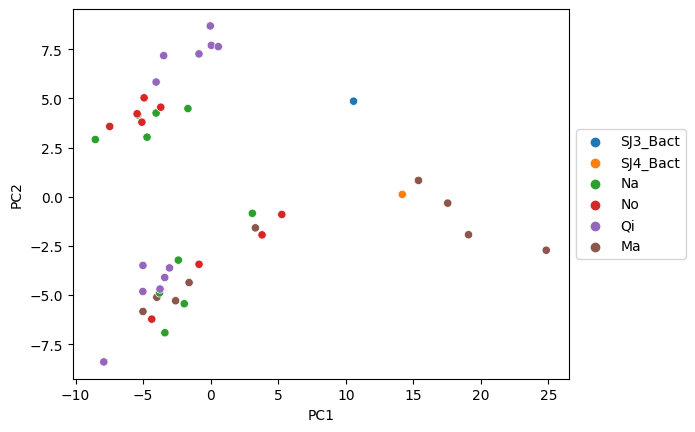

In [110]:
ax = sns.scatterplot(x="PC1", y="PC2", hue='Method', legend=True, data=pct_df)
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


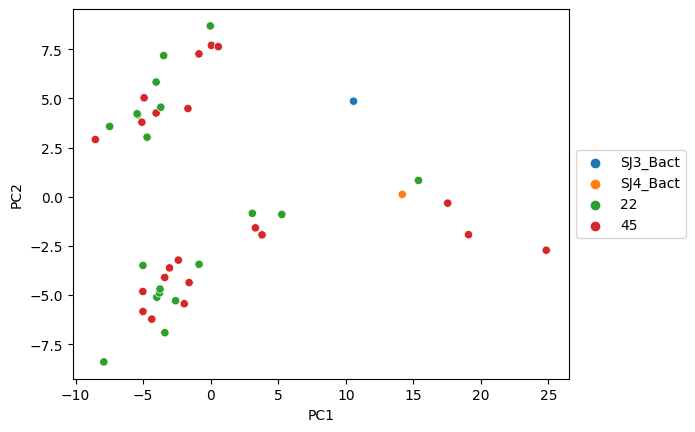

In [111]:
ax = sns.scatterplot(x="PC1", y="PC2", hue='Filter', legend=True, data=pct_df)
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


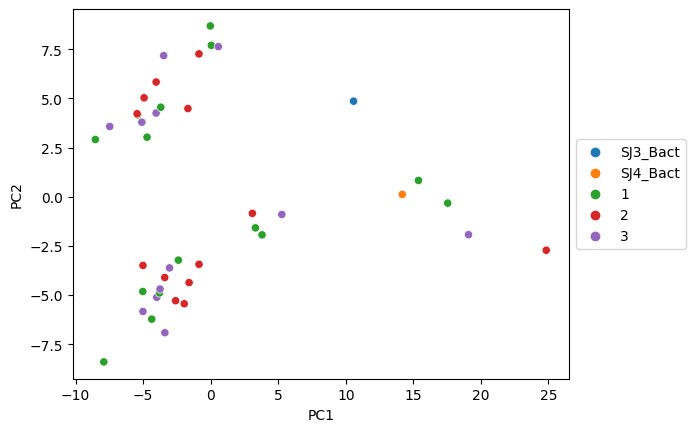

In [112]:
ax = sns.scatterplot(x="PC1", y="PC2", hue='Rpt', legend=True, data=pct_df)
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [113]:
ax = sns.scatterplot(x="PC1", y="PC2", hue=['Sample', 'Approach', 'Method'], legend=True, data=pct_df)
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 42 and the vector passed to `hue` has length 3.